In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import nn_model
import loss
import metrics
import train_epoch_qat
import val_epoch
import utils

from neural_compressor import QuantizationAwareTrainingConfig
from neural_compressor.training import prepare_compression

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\t255 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tQAT with Neural Compressor. Version 0.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

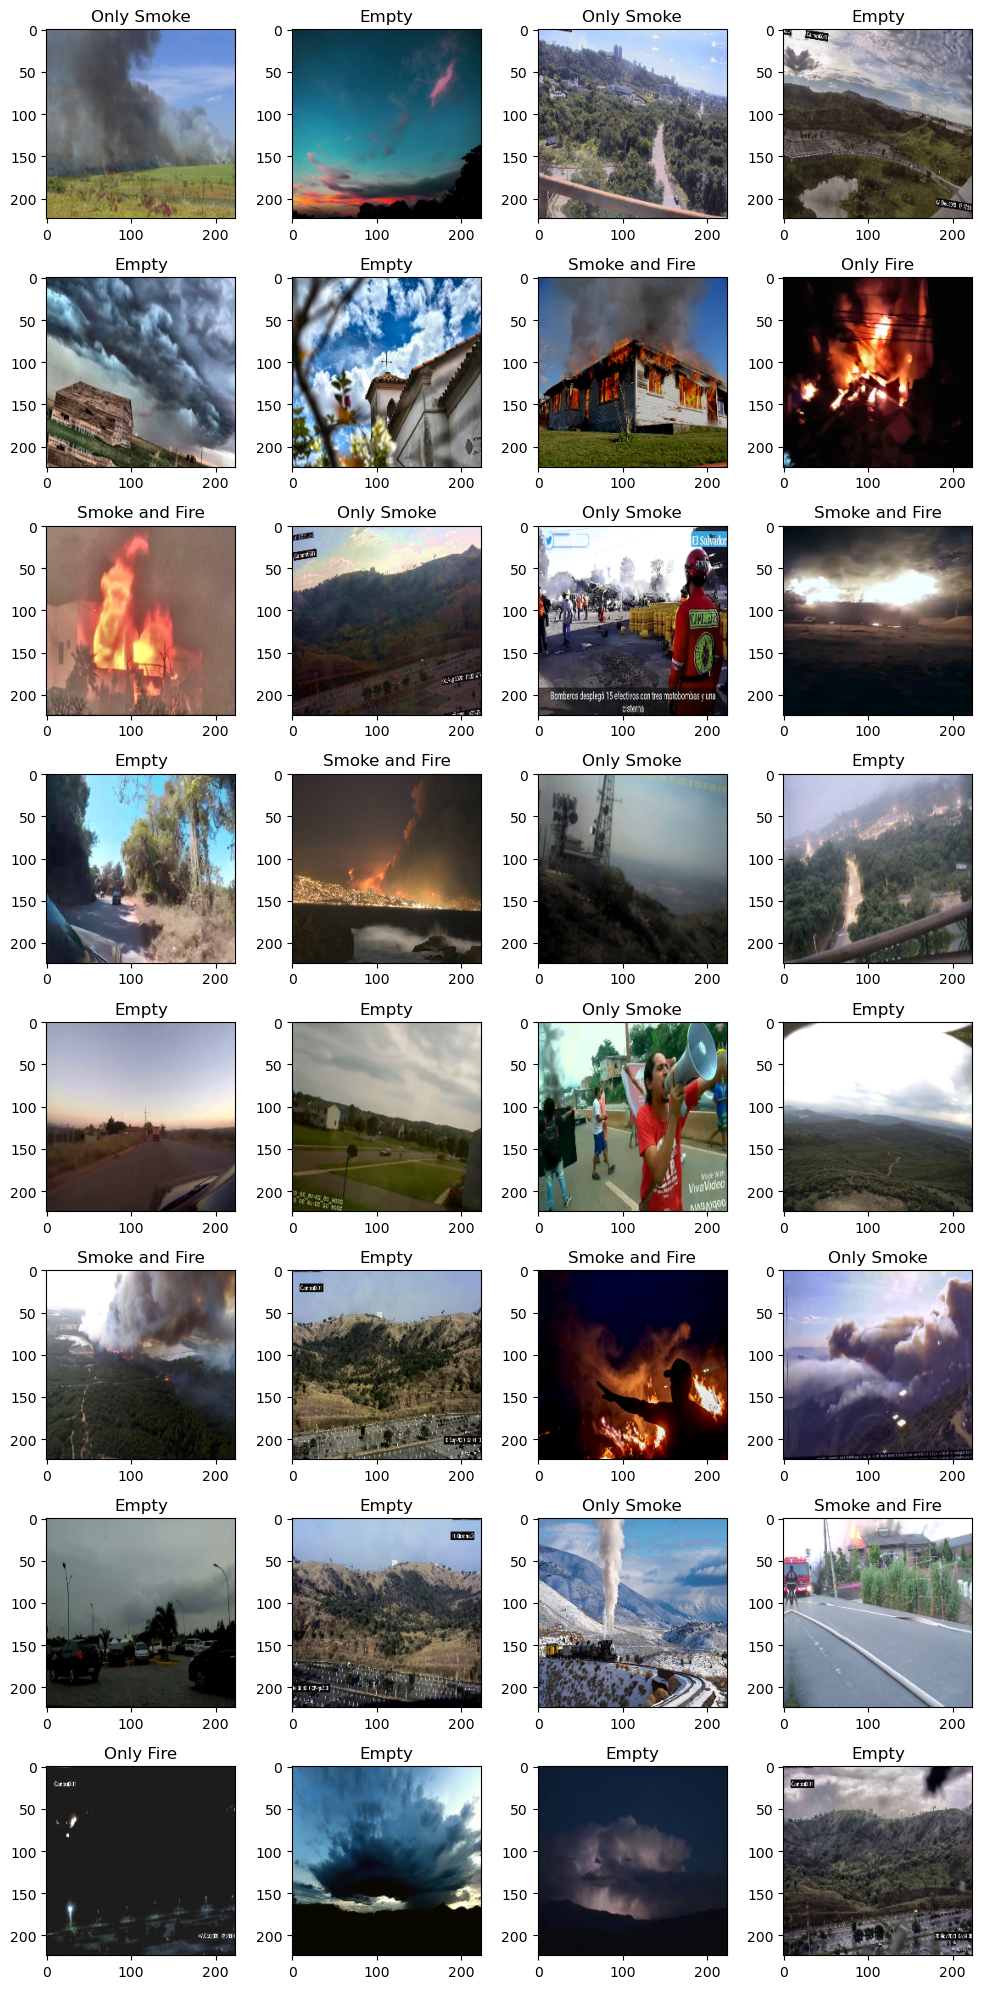

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [8]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = nn_model.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)  
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[0.3757, 0.1575],
        [0.3084, 0.1958],
        [0.4314, 0.1866],
        [0.3029, 0.1293]], grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False,

# Torchinfo: model summary

In [9]:
print(summary(model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 224, 224]        --
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-4                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 16, 112, 112]        4,608
│    └─BatchNorm2d: 2-7                  [64, 16, 112, 112]        --
│    └─ReLU: 2-8                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-9                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-10                   [64, 16, 56, 56]          --
│    └─Conv2d: 2-11                      [64, 16, 56, 56]          256
│    └─Bat

# Initialize Empty Model o Load Trained Model

In [10]:
start_epoch = 0

# if config.LOAD_MODEL == False:
#     if config.MODEL == "BED":
#         model.__initialize_weights__()
#         print("Initializing Weights")
#         logger.info("Initializing Weights")
# else:
#     checkpoint = torch.load(LOAD_MODEL_FILE)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#     start_epoch = checkpoint['epoch']
#     print(f"Loading Model. Train from epoch: {start_epoch}")
#     logger.info(f"Loading Model. Train from epoch: {start_epoch}")

# Print and Log Config Values

In [11]:
''' ============================
    Print Config Values
============================ '''
print(f'Device: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'Device: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


# LOSS FUNCTION
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'Loss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Device: cpu
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
Loss Function: BCE
Smoke Precision Weight: 0.7


# Loss and Metrics Loggers and Plotters

In [12]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [13]:
def train_loop(model):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #****************** Quantization ******************#
        compression_manager.callbacks.on_epoch_begin(epoch)
        #**************************************************#
        
        #====================== TRAINING ========================#
        logger.info(f'Learning Rate = {train_epoch_qat.get_lr(optimizer=optimizer)}\n')
        
        train_losses, train_metrics = train_epoch_qat.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE, 
            comp_mng=compression_manager)
        
        #****************** Quantization ******************#
        compression_manager.callbacks.on_epoch_end()
        #**************************************************#
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + config.MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + config.MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + config.MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [14]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    
    conf = QuantizationAwareTrainingConfig()
    compression_manager = prepare_compression(model, conf)
    model = compression_manager.model
    compression_manager.callbacks.on_train_begin()
        
    train_loop(model)
    
    compression_manager.callbacks.on_train_end()
    compression_manager.save("./qat_v0/output") 

/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/ao/quantization/fx/fuse.py:56: UserWarning: Passing a fuse_custom_config_dict to fuse is deprecated and will not be supported in a future version. Please pass in a FuseCustomConfig instead.
  warnings.warn(
2024-06-21 15:47:33 [INFO] Attention Blocks: 0
2024-06-21 15:47:33 [INFO] FFN Blocks: 0
2024-06-21 15:47:33 [INFO] Fx trace of the entire model failed. We will conduct auto quantization


Starting script



/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


TypeError: 'NoneType' object is not callable